In [1]:
%reload_ext autoreload
%autoreload 2

from pathlib import Path
from collections import defaultdict
import json
import torch
import torch.nn.functional as F
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt

from torchvtk.utils import make_4d, make_5d, tex_from_pts
from torchvtk.rendering import plot_tf

from pytorch3dunet.unet3d.model import UNet3D, ResidualUNet3D
from torchviz import make_dot

from rle_shit import decode_from_annotation

pltkwargs = {
    'dpi':  200,
    'tight_layout': True
}

In [2]:
male_ub = torch.load('/run/media/dome/Data/data/Volumes/DVS_Test/CT/male-upperbody.pt')
vol = torch.from_numpy(male_ub['vol'].astype(np.float32)).float() / 4095.0
print(vol.shape, vol.dtype, vol.min(), vol.max())

torch.Size([512, 512, 460]) torch.float32 tensor(0.) tensor(1.)


Text(0.5, 1.0, 'Sliced along Z')

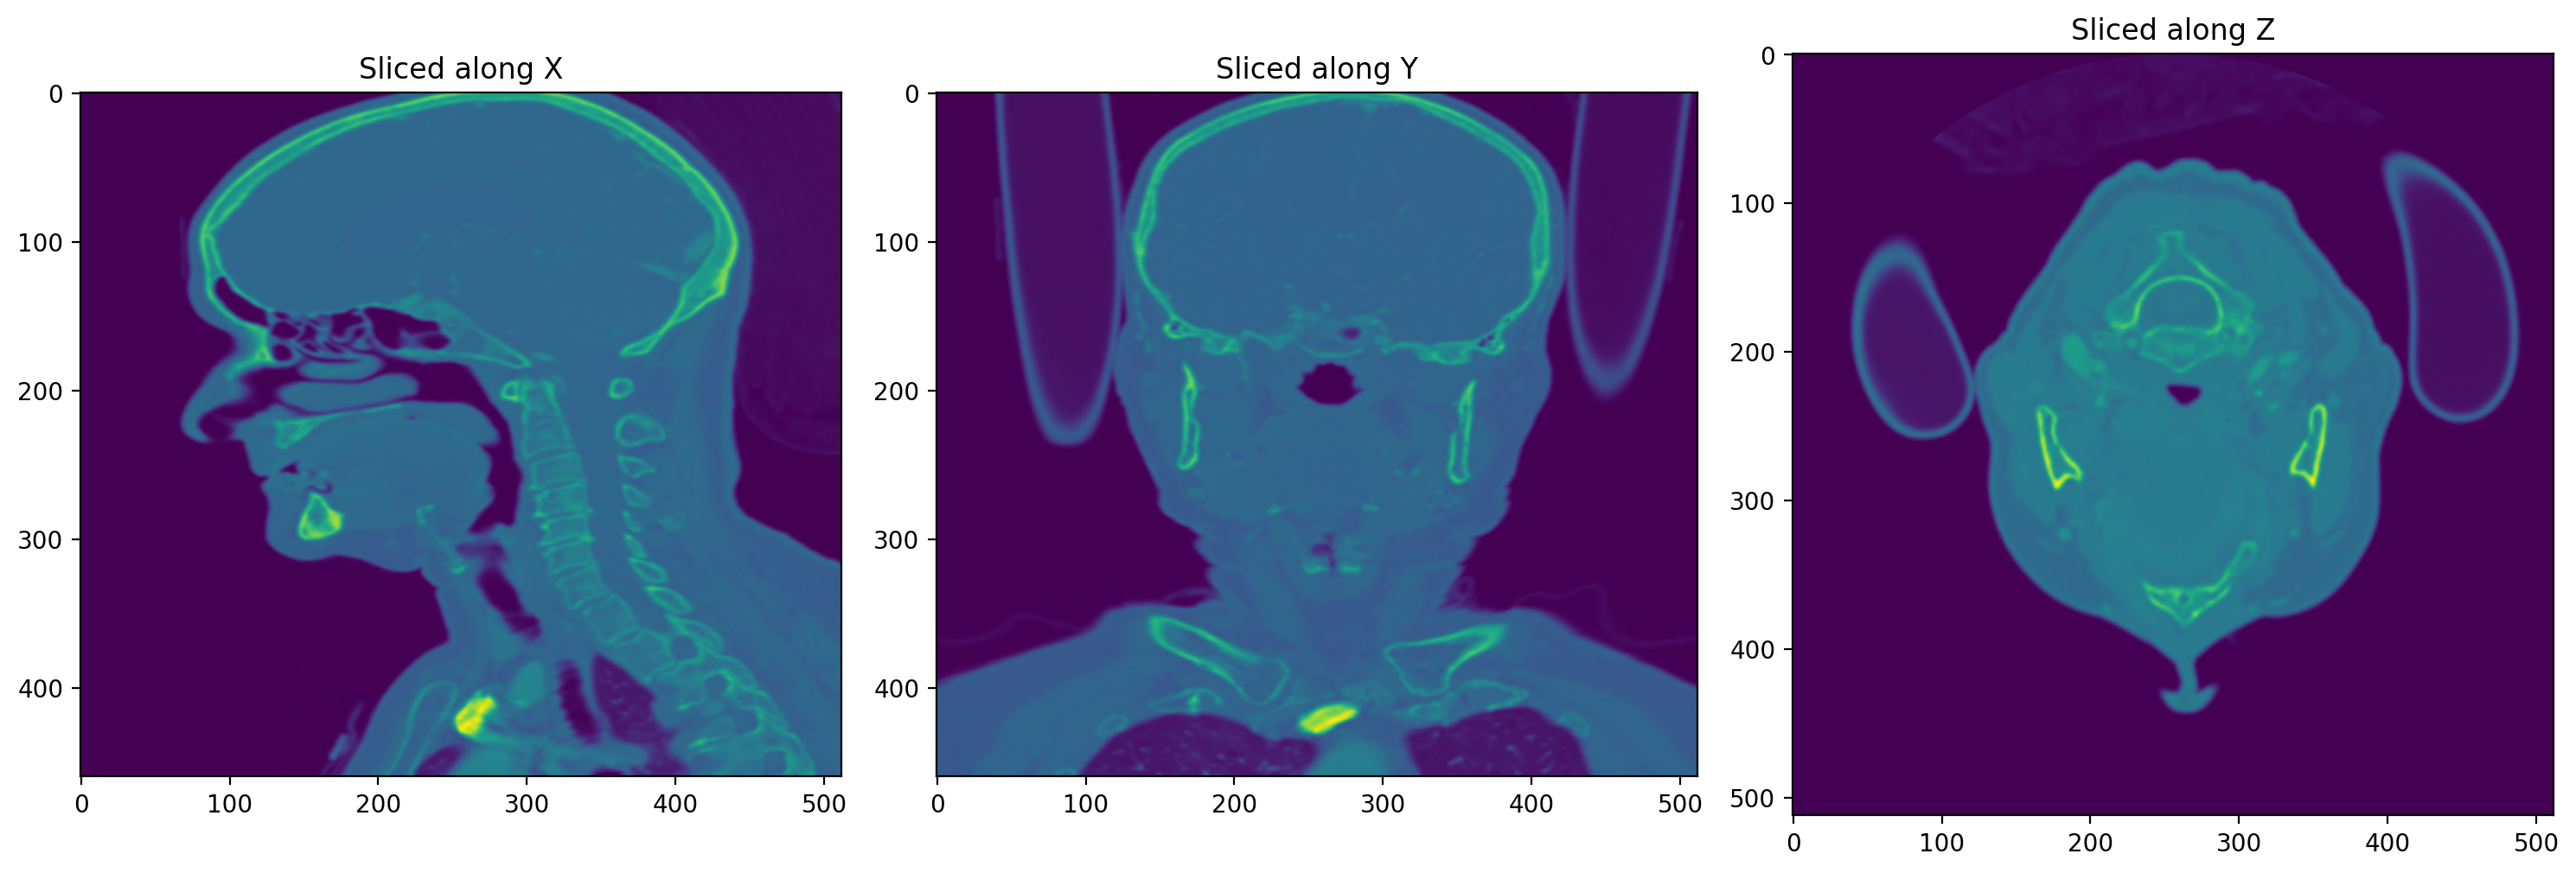

In [3]:
fig, ax = plt.subplots(1,3, figsize=(15,5), **pltkwargs)
ax[0].imshow(vol[256, :, :].rot90())
ax[0].set_title('Sliced along X')
ax[1].imshow(vol[:, 256, :].rot90())
ax[1].set_title('Sliced along Y')
ax[2].imshow(vol[:, :, 230].rot90())
ax[2].set_title('Sliced along Z')


In [4]:
x_slices = [(i, (slice(i, i+1), slice(None), slice(None))) for i in range(0, vol.size(0), 32)]
y_slices = [(i, (slice(None), slice(i, i+1), slice(None))) for i in range(0, vol.size(1), 32)]
z_slices = [(i, (slice(None), slice(None), slice(i, i+1))) for i in range(0, vol.size(2), 32)]

In [5]:
out_dir = Path('data/male_ub_slices/')
if out_dir.stat().st_size == 0:
    for i, idx in x_slices:
        save_image(vol[idx].squeeze(), out_dir / f'x_{i:03d}.png')
    for i, idx in y_slices:
        save_image(vol[idx].squeeze(), out_dir / f'y_{i:03d}.png')
    for i, idx in z_slices:
        save_image(vol[idx].squeeze(), out_dir / f'z_{i:03d}.png')


In [6]:
with open('data/sample.json') as f:
    labels = json.load(f)

In [7]:
def extract_masks(ims):
    def dim2slice(dimstr):
        dim, idxstr = dimstr.split('_')
        idx = int(idxstr)
        if dim == 'x': return (slice(idx, idx+1), slice(None), slice(None))
        if dim == 'y': return (slice(None), slice(idx, idx+1), slice(None))
        if dim == 'z': return (slice(None), slice(None), slice(idx, idx+1))
        else: raise Exception(f'Shit gone wrong, dim from filename is neither x,y,z. It is {dim}')
    ret = defaultdict(list)
    for d in ims:
        for k,v in d.items():
            slc, nam, _ = k.split('-')
            ret[nam].append({'idx': dim2slice(slc), 'mask': torch.from_numpy(v).bool()})
    return ret

In [8]:
def merge_masks_to_volume(volume, masks):
    vol_mask = {k: torch.zeros(volume.shape, dtype=torch.bool, device=volume.device) for k in masks.keys()}
    for label, maskl in masks.items():
        for mask in maskl:
            vol_mask[label][mask['idx']] += mask['mask'].view_as(vol_mask[label][mask['idx']])
    return vol_mask

In [18]:
ims = [
    decode_from_annotation(label['data']['image'][-9:-4], an['result'])
    for label in labels for an in label['annotations'] if len(an['result']) > 0
]
masks = extract_masks(ims)
mask_vol = merge_masks_to_volume(vol, masks)
mask_idxs = {k: v.nonzero() for k,v in mask_vol.items()}

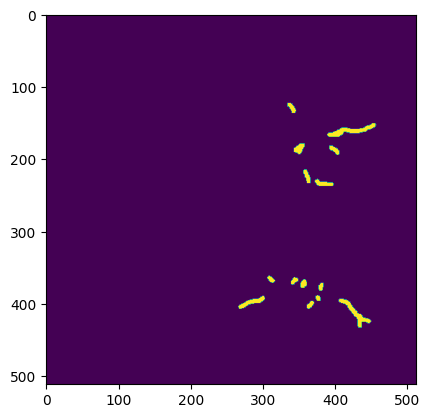

In [10]:
plt.imshow(masks['Lung'][0]['mask'])

In [11]:
SCALE_FACTOR = 0.25
vol_half   =      F.interpolate(make_5d(vol), scale_factor=SCALE_FACTOR, mode='trilinear')
masks_half = { k: F.interpolate(make_5d(m.to(torch.uint8)), scale_factor=SCALE_FACTOR, mode='nearest')[0,0].bool() for k,m in mask_vol.items() }
print(vol_half.shape, {k: v.shape for k,v in masks_half.items()})

torch.Size([1, 1, 128, 128, 115]) {'Lung': torch.Size([128, 128, 115]), 'Skin': torch.Size([128, 128, 115]), 'Bone': torch.Size([128, 128, 115]), 'Meat': torch.Size([128, 128, 115])}


In [19]:
mask_idxs['Lung'].shape

torch.Size([2799, 3])

In [20]:
model = UNet3D(1, 32, final_sigmoid=False, f_maps=16, is_segmentation=False).cuda()
with torch.no_grad():
    feat = model(vol_half.cuda())
#make_dot(y.mean(), params=dict(model.named_parameters()))

In [23]:
from moco import MoCo

In [24]:
moco_model = MoCo(UNet3D, 32, {
    'in_channels': 1, 
    'out_channels': 32, 
    'final_sigmoid': False, 
    'f_maps': 16, 
    'is_segmentation': False
})

In [26]:
with torch.no_grad():
    logits, labels, features = moco_model(vol_half.cuda())

TypeError: MoCo.forward() missing 3 required positional arguments: 'im_k', 'correspondence_q', and 'correspondence_k'

In [32]:
feats = { k: feat[:, :, mask] for k,mask in masks_half.items() }

In [36]:
feat.std()

tensor(0.2999, device='cuda:0')

In [35]:
print({k: torch.std(v) for k,v in feats.items() })

{'Lung': tensor(0.2883, device='cuda:0'), 'Skin': tensor(0.4729, device='cuda:0'), 'Bone': tensor(0.3621, device='cuda:0'), 'Meat': tensor(0.2458, device='cuda:0')}


In [37]:
model

UNet3D(
  (encoders): ModuleList(
    (0): Encoder(
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(1, 1, eps=1e-05, affine=True)
          (conv): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
        (SingleConv2): SingleConv(
          (groupnorm): GroupNorm(8, 8, eps=1e-05, affine=True)
          (conv): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
      )
    )
    (1): Encoder(
      (pooling): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(8, 16, eps=1e-05, affine=True)
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
        

In [42]:
from moco import MoCo

In [40]:
from functools import partial

In [43]:
mocmodel = MoCo(partial(UNet3D, 1, 32), 32, {
    'final_sigmoid': False,
    'f_maps': 16,
    'is_segmentation': False}
)


In [44]:
from torchvision.transforms import RandomRotation

In [45]:
rot = RandomRotation(15.0)
torch.meshgrid(torch.linspace(-1, 1, 64))
cor_grid = rot(torch)

In [ ]:
logits, labels = mocmodel(torch.randn(2, 1, 64,64,64), torch.randn(2,1, 64,64,64))